In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
def process_one_seed(num_peers, seed):
    file_pattern = f'../results/{num_peers}/{seed}/ifstat_*.log'
    file_paths = sorted(
        glob.glob(file_pattern),
        key=lambda x: int(re.search(r'h(\d+)\.log$', x).group(1))
    )

    raw_data = []  # This will contain N lists (one per file)
    for file_path in file_paths:
        file_sums = []  # Sum of the two floats per line
        with open(file_path, 'r') as f:
            # Skip first two lines
            next(f, None)
            next(f, None)

            # Process remaining lines
            for line in f:
                parts = line.strip().split()
                
                # Check if line has exactly two values that can be converted to float
                if len(parts) == 2:
                    try:
                        val1 = float(parts[0])
                        val2 = float(parts[1])
                        # Add the two values line-by-line
                        file_sums.append(val1 + val2)
                    except ValueError:
                        # Stop reading this file if we can't parse two floats
                        break
                else:
                    # Stop reading this file if line doesn't have two values
                    break
        raw_data.append(file_sums)

    min_length = min(len(sums) for sums in raw_data)
    trimmed_data = [entry[:min_length] for entry in raw_data]

    # Iterate over time (100 mS) and calculate average per participating peers. 
    # t-2~3: ifstat start
    # t0: Scenario start
    # t1: Dial
    # t2: Join
    averaged_netuse = []
    for i in range(min_length):
        # round 0: initial 10
        # round 1: add 10 (20)
        round = 0 if i < 80 else (i - 80) // 120
        participating_peer_count = 10 + 10 * round

        sum = 0
        for file_data in trimmed_data[:participating_peer_count]:
            sum += file_data[i]

        averaged_netuse.append(sum / participating_peer_count)

    return averaged_netuse

    

In [14]:
all_results = [process_one_seed(300, seed) for seed in range(0, 10)]

In [20]:
measure_timepoint_count = len(all_results[0])
offset = 80
block_size = 120
blocks = (measure_timepoint_count - 80) // 120
block_duration = block_size/10

result_partial_sums = []
for measurement in all_results: # measurement is long 1D float array.
    this_partial_sums = []
    for b in range(blocks): # for each join session 
        raw_data = measurement[offset + block_size * b : offset + block_size * (b + 1)]
        netuse_sum = 0
        for r in raw_data:
            netuse_sum += r * 0.1 # kb/s * 100mS
        
        this_partial_sums.append(netuse_sum/block_duration)
    result_partial_sums.append(this_partial_sums)

part_begin_time = [offset/10 + block_size*i/10 for i in range(blocks)]

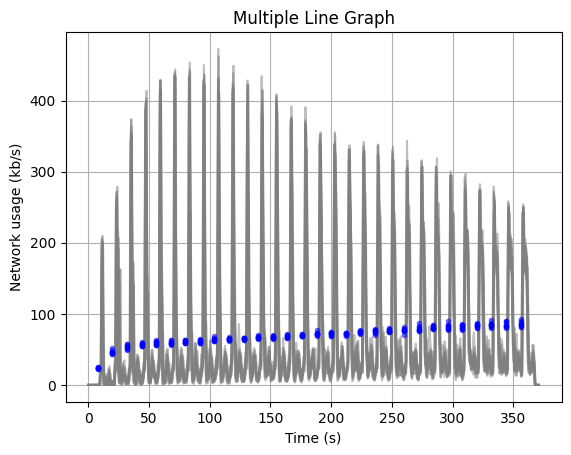

In [25]:
# Plot each list as a separate line
window = 10

for i, line_data in enumerate(all_results):
    x_values = [0.1 * idx for idx in range(len(line_data))][:(1-window)]
    plt.plot(x_values, np.convolve(line_data, np.ones(window)/window, mode='valid'), color='gray', alpha=0.5)
    # x_values = [0.1 * idx for idx in range(len(line_data))]
    # plt.plot(x_values, line_data, color='gray', alpha=0.5)

for partial_sum in result_partial_sums:
    plt.plot(part_begin_time, partial_sum, '.', color='blue', alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Network usage (kb/s)')
plt.title('Multiple Line Graph')
plt.grid(True)
plt.savefig('plot.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
plt.close()

In [ ]:
#==============================================
NUM_PEERS = 10
SEED = 0

In [ ]:
# Step 1: Read all ifstat_*.log files
file_pattern = f'../results/{NUM_PEERS}/{SEED}/ifstat_*.log'
file_paths = sorted(glob.glob(file_pattern))

print(f"Found {len(file_paths)} files:")

In [ ]:
# Step 2: Parse each file and create lists of sums
all_sums = []  # This will contain N lists (one per file)

for file_path in file_paths:
    file_sums = []  # Sum of the two floats per line
    
    with open(file_path, 'r') as f:
        # Skip first two lines
        next(f, None)
        next(f, None)
        
        # Process remaining lines
        for line in f:
            parts = line.strip().split()
            
            # Check if line has exactly two values that can be converted to float
            if len(parts) == 2:
                try:
                    val1 = float(parts[0])
                    val2 = float(parts[1])
                    # Add the two values line-by-line
                    file_sums.append(val1 + val2)
                except ValueError:
                    # Stop reading this file if we can't parse two floats
                    break
            else:
                # Stop reading this file if line doesn't have two values
                break
    
    all_sums.append(file_sums)

In [ ]:
# Step 3: Calculate average at each index across all files
# Find the minimum length to ensure all files have data at each index
min_length = min(len(sums) for sums in all_sums)

# Calculate averages at each index
averaged_netuse = []
for i in range(min_length):
    # Get the value at index i from each file
    values_at_index = [file_sums[i] for file_sums in all_sums]
    # Calculate average
    avg = np.mean(values_at_index)
    averaged_netuse.append(avg)

In [ ]:
# Create the plot
plt.plot(averaged_netuse)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Graph')
plt.grid(True)
plt.savefig('plot.jpg', bbox_inches='tight')